# Data inspector

#### Some functions are taken from https://github.com/thomasvanorden/LBS/tree/segmentation

## 0. Imports

In [2]:
#To be at project directory root and not in the Notebooks folder
%cd ~/CBS2

#Imports
import lmdb
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
import glob

/home/fhoekstra/CBS2


## 1. Dataset

In [3]:
dataset_path = "dataset/splitted_dataset"
#repetitions = [x[0] for x in os.walk(dataset_path)][1:]
#print('Found {} repetitions'.format(len(repetitions)))
#print(repetitions)
paths_t = [x[0] for x in os.walk(dataset_path + os.path.sep + 'train')][1:]
paths_v = [x[0] for x in os.walk(dataset_path + os.path.sep + 'val')][1:]
print('Found {} train episodes and {} val episodes'.format(len(paths_t), len(paths_v)))

Found 291 train episodes and 77 val episodes


### 1.1 Decode dataset

In [4]:
# Used to extract the dataset into the global dict 'dataset'
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

# Will decode the frame at the given timestep from the global variable dataset
def decode_frame(step):
    data = {'rgb':None, 'segmentation': None, 'birdview': None, 'loc': None, 'rot': None, 'spd': None, 'cmd': None, 'trafficlights': None, 'cam_location': None, 'cam_rotation': None}

    for t in data.keys():
        d = dataset["{}_{:04d}".format(t, step)]
        data[t] = decode_data(d, kind=t)

    return data

# Used by 'decode_frame' to convert the data in the appropriate format
def decode_data(data, kind='rgb'):
    if kind == 'loc' or kind == 'rot' or kind == 'spd' or kind == 'cmd' or kind == 'cam_location' or kind == 'cam_rotation':
        return np.frombuffer(data, dtype=np.float32)

    img = np.frombuffer(data, dtype=np.uint8)

    if kind == 'trafficlights':
        return int.from_bytes(data, 'little')
    elif kind == 'rgb':
        img = img.reshape((160, 384, 3))
    elif kind == 'segmentation':
        img = img.reshape((160, 384))
    elif kind == 'birdview':
        img = img.reshape((96, 96, -1))
        
    else:
        raise ValueError("Not known type {}. Choose from: rgb, birdview, segmentation.".format(kind)) 

    return img

### 1.2 Information on dataset

In [5]:
def get_episode_info():
    cmds = []
    is_red_tl = []
    for i in range(int(dataset['len'].decode())):
        is_red_tl.append(decode_frame(i)['trafficlights'])
        cmds.append(int(decode_frame(i)['cmd'])+1)
        
    counter_cmds = Counter(cmds)
    count_left = counter_cmds[1]
    count_right = counter_cmds[2]
    count_straight = counter_cmds[3]
    count_follow = counter_cmds[4]
    
    counter_is_red_tl = Counter(is_red_tl)
    count_red = counter_is_red_tl[0]
    count_frames = sum(counter_is_red_tl.values())
    
    infos = [count_frames, count_left, count_right, count_straight, count_follow, count_red]
    return infos

def save_dataset_info(path_list, filename):
    global dataset
    n_episodes = len(path_list)
    with open(filename,"w") as savefile:     
        for i, path in enumerate(path_list):
            dataset = decode_dataset(path)
            if len(dataset) != 0:
                row = get_episode_info()
                np.savetxt(savefile, row, fmt='%i', delimiter=",")
                
def retrieve_dataset_info(filename):
    retrieved = np.fromfile(filename, sep='\n').astype(int).reshape(-1,6)
    print('Retrieved {} episodes'.format(retrieved.shape[0]))
    retrieved = np.sum(retrieved, axis=0)
    
    total_frames = retrieved[0] # Total frames
    total_intersection_frames = retrieved[0]-retrieved[4] # Total frames (excluding 'follow lane ones')

    rates_cmd = 100 * retrieved[1:4] / total_intersection_frames # Mean Left, Right, Straight (we do not care about follow)
    rate_intersection = 100 * (1 - retrieved[4] / total_frames)
    rate_red = 100 * retrieved[5] / total_frames
    rates_inter_and_red = np.hstack((rate_intersection, rate_red)) # Mean red TL frames
    return rates_cmd, rates_inter_and_red

### 1.3 Retrieve and plots

In [6]:
info_file_t = 'Notebooks/final_train.txt'
info_file_v = 'Notebooks/final_val.txt'
dataset = dict()

#save_dataset_info(paths_t, info_file_t)
#save_dataset_info(paths_v, info_file_v)

cmd_rates_t, rates_inter_and_red_t = retrieve_dataset_info(info_file_t)
cmd_rates_v, rates_inter_and_red_v = retrieve_dataset_info(info_file_v)
cmd_rates = np.vstack((cmd_rates_t, cmd_rates_v))
rates_inter_and_red = np.vstack((rates_inter_and_red_t, rates_inter_and_red_v))

#assert(np.mean(np.sum(cmd_rates_t)==100.0)) #Should be 100%

Retrieved 131 episodes
Retrieved 33 episodes


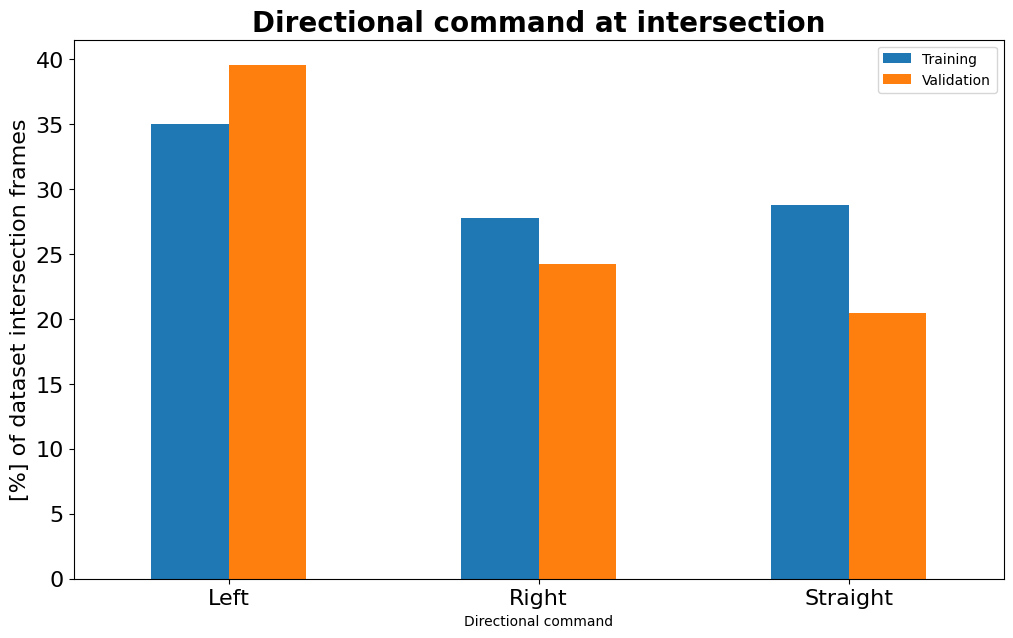

In [7]:
legends = ['Training', 'Validation']
x_title = 'Directional command'
plot_labels = ['Left', 'Right', 'Straight']

metrics = pd.DataFrame(np.array([cmd_rates[:,i] for i in range(3)]), columns=legends)
ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
ax.set_xlabel(x_title)
x = np.arange(len(plot_labels))
ax.set_xticks(x)
ax.set_xticklabels(plot_labels, fontsize=16, rotation='horizontal')
ax.set_ylabel("[%] of dataset intersection frames", fontsize=16)
plt.title("Directional command at intersection", fontsize=20, weight='bold')
plt.savefig('Notebooks/plots/dataset/dataset_cmd.png')


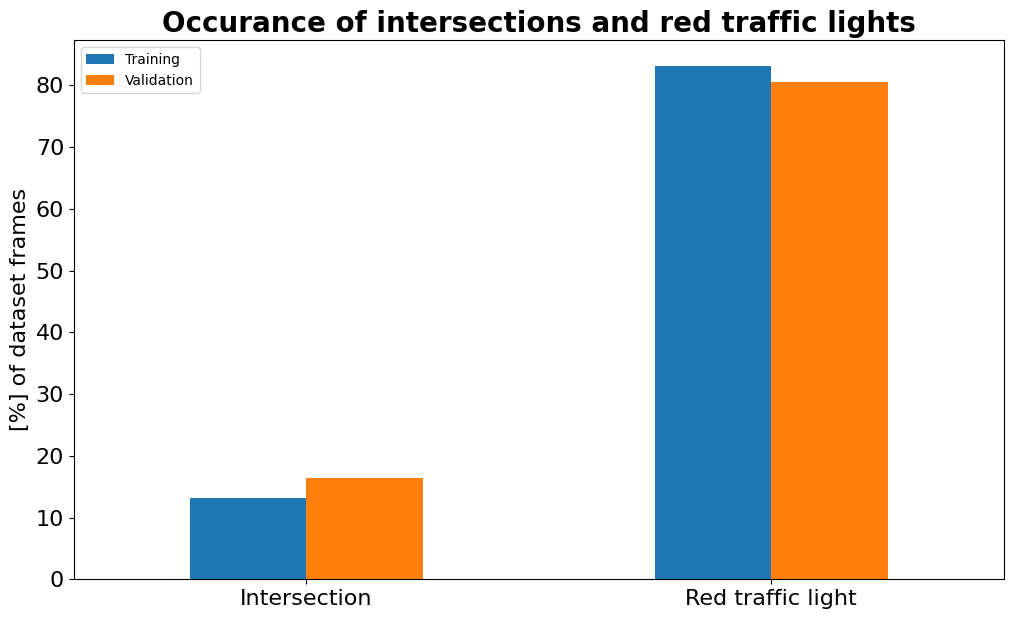

In [8]:
legends = ['Training', 'Validation']
#x_title = 'Dataset'
plot_labels = ['Intersection', 'Red traffic light']

metrics = pd.DataFrame(np.array([rates_inter_and_red[:,i] for i in range(2)]), columns=legends)
ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
#ax.set_xlabel(x_title)
x = np.arange(len(plot_labels))
ax.set_xticks(x)
ax.set_xticklabels(plot_labels, fontsize=16, rotation='horizontal')
ax.set_ylabel("[%] of dataset frames", fontsize=16)
plt.title("Occurance of intersections and red traffic lights", fontsize=20, weight='bold')
plt.savefig('Notebooks/plots/dataset/dataset_red.png')

In [9]:
from pathlib import Path
import torch
import lmdb
import os
import glob
import numpy as np
import cv2
import math
import random

PIXEL_OFFSET = 10
N_TRAFFIC_LIGHT_STATES = 1
SEG_CLASSES = {4, 6, 7, 10, 18}  # pedestrians, roadlines, roads, vehicles, tl

buffer = 40
n_step = 5
gap= 5


def project_vehicle(converter, x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x, y, z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    #new_pos = pos + 4 * ori
    fwd_2d_angle = np.deg2rad(ori_y) #yaw to rad
    new_pos = pos + 5.5 * np.array([np.cos(fwd_2d_angle), np.sin(fwd_2d_angle), 0])
    new_pos_cam_coords = converter.convert(np.array([new_pos]))
    if(new_pos_cam_coords.shape[0] == 0):
        return np.array([[192, 147, 0]]) # In the center of the image, almost at the bottom --> stop waypoint
    return new_pos_cam_coords


def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit first or second function through points
    n_degree = 2 if points.shape[0] > 2 else 1
    z = np.polyfit(points[:, 0], points[:, 1], n_degree)
    p = np.poly1d(z)

    # Keep interpolating until we have n_step points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points - points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(converter, index, world_x, world_y, world_z, ori_x, ori_y, ori_z):
    global buffer
    global n_step
    global gap
    

    tl = decode_frame(index)['trafficlights']
    speed = decode_frame(index)['spd'][0]

    output = []
    #if tl or vehicle or walker:
    if tl:
    #if tl or speed < 0.005:
        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        if tl:
            return output, 3 # Traffic light --> stop
        else:
            return output, 4 # TObstacle --> stop

    for i in range(index, (index + (n_step + 1 + buffer * gap)), gap):
        if len(output) == n_step:
            break

        x, y, z = decode_frame(i)['loc']
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if gap > 1:
            gap = 1
            return get_waypoints(converter, index, world_x, world_y, world_z,ori_x, ori_y, ori_z)

        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x,ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        #return output, True
        return output, 2 # Less than two waypoints --> stop

    if 2 <= len(output) < n_step:
        return interpolate_waypoints(converter, np.array(output)), 1 # Interpolation
    #return np.array(output), False
    return np.array(output), 0 # All waypoints ok

    

In [10]:
from image_utils import CoordinateConverter, Location, Rotation, Transform 

font = cv2.FONT_HERSHEY_SIMPLEX
#dataset = decode_dataset(train_paths[478])
debug_paths = [x[0] for x in os.walk('dataset/final' + os.path.sep + 'train')][1:]


img_array=[]
tls_array=[]
size = (384,160)

for p in debug_paths[:10]: 
    dataset = decode_dataset(p)
    N = int(dataset['len'].decode())
    print(N)
    title_img = np.zeros(shape=(160, 384, 3), dtype=np.uint8)
    size = (384,160)
    cv2.putText(title_img, p, (50,50), font, 0.3, (0, 255, 255), 1, cv2.LINE_8)
    for i in range(15):
        img_array.append(title_img)
    try:
        for i in range(N):
            frame = decode_frame(i)
            img = frame['rgb']
            if img is not None:
                height, width, layers = img.shape
                size = (width,height)
                world_x, world_y, world_z = frame['loc']
                ori_x, ori_y, ori_z = frame['rot']
                speed = frame['spd'][0]
                speed = np.abs(speed)
                cmd = int(frame['cmd'][0])
                cam_x, cam_y, cam_z = frame['cam_location']
                cam_pitch, cam_yaw, cam_roll = frame['cam_rotation']

                sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_pitch, cam_yaw, cam_roll))
                #print('Cam {} {} {} {} {} {}'.format(cam_x, cam_y, cam_z, cam_pitch, cam_yaw, cam_roll))
                converter = CoordinateConverter(sensor_transform, fov=120)

                image_coord_wp, method = get_waypoints(converter,i, world_x, world_y, world_z, ori_x, ori_y, ori_z)
                method = {
                    0: 'InFrame', 1: 'Intrpl', 2: '<2',
                    3: 'Stop(TL)', 4: 'Stop(Obs)'}.get(method)
                cmd = {
                    0: 'LEFT', 1: 'RIGHT',
                    2: 'STRAIGHT', 3: 'FOLLOW'}.get(cmd)

                for coords in image_coord_wp:
                    c = coords[:2]
                    cv2.circle(img, (int(c[0]), int(c[1])), 1, (255,0,0), 5)

                tls = frame['trafficlights']
                
                
                img = cv2.putText(img, f'RTLS:{tls}  spd:{speed:.2f} {cmd} {method} ', (10,10), font, 0.3, (0, 255, 255), 1, cv2.LINE_8)
                img_array.append(img)

    except:
        print('Next episode')
out = cv2.VideoWriter('dataset_episode.mp4',0x7634706d, 8, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print('Finished')

Finished


In [13]:
dataset = decode_dataset(paths_t[0])

for i in range(0, 292):
    try:
        frame = decode_frame(i)
        if 'rgb' in frame:
            rgb = frame['rgb']
            b = rgb[:,:,0]
            g = rgb[:,:,1]
            r = rgb[:,:,2]
            rgb = np.moveaxis(np.array([r,g,b]), 0, -1)
            plt.imsave(f'{i}.png', rgb)
        else:
            print(f"No 'rgb' data found for index {i}")
    except KeyError as e:
        print(f"KeyError: {e}")


4881it [00:00, 158759.83it/s]


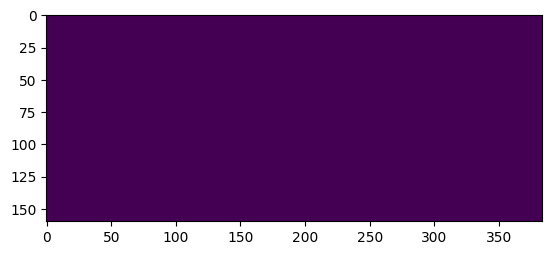

In [42]:
seg = decode_frame(150)['segmentation']
plt.imshow(seg==18)

In [ ]:
dataset.keys()


[ 0  1  2  4  5  6  7  8  9 10 11 12 13 19 20 22]
[[13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [13 13 13 13 13 13 13 13 13 13 13 13  9  9 13 13 13 13 13  9]
 [13 13 13 13 13 13 13 13 13 13 13 13  9  9 13 13 13 13 13  9]
 [13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9 13 13  9]
 [13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9 13 13  9]
 [13 

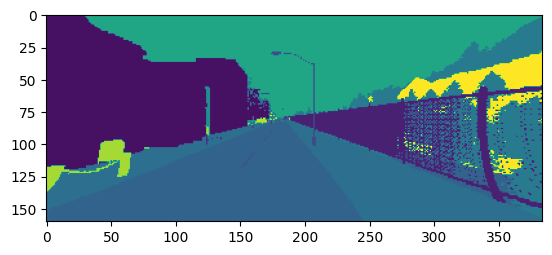

In [46]:
seg = decode_frame(487)['segmentation']
print(np.unique(seg))
print(seg[50:100,230:250])
plt.imshow(seg)